In [54]:
from numpy import *
# from matplotlib.pyplot import *
# import os
# ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals


def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = sqrt(sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = sqrt(sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = eigVals[0]

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge


def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [2]:
def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    
    flat = flattenData(FinalRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return FinalRegions, final_values

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge



In [3]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total


import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids_diverse.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')

In [4]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

# Method3

In [70]:
def trimEnds(values, lists):
    begining = 4
    ends = len(values) - 5
    isInclude = True
    for item in lists:
        if item < begining or item > ends:
            isInclude = False
    return isInclude

def splitRegions(currlist):
    sortList = sort(currlist)
    
    region_list = []
    currRegion = []
    previous = -1
    for item in sortList:
        if item - previous == 1:
            currRegion.append(item)
            previous = item
        else:
            if currRegion != []:
                region_list.append(currRegion)
            currRegion = [item]
            previous = item
    
    if currRegion not in region_list:
        region_list.append(currRegion)
    return region_list
        
def extendRegions(crossovers, values, thereshold):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    return regions

def mergeRegions(lists, max_gap=2, min_length=5):
    merged = [lists[0]]  # Start with the first list

    for next_list in lists[1:]:
        # Check if the next list starts within max_gap+1 of the last element of the current last list in 'merged'
        if next_list[0] - merged[-1][-1] <= max_gap + 1:
            # Merge the lists by extending the last list in 'merged' with the elements of 'next_list'
            merged[-1].extend(next_list)
        else:
            # If it doesn't meet the merge criteria, just append the list as a new one
            merged.append(next_list)

    # Filter merged lists to ensure they meet the min_length requirement after removing duplicates and sort them
    # Keep unmerged lists as they are
    final_list = []
    for sublist in merged:
        unique_sublist = sorted(set(sublist))  # Remove duplicates and sort
        if len(unique_sublist) >= min_length or unique_sublist == sublist:  # Check length or unchanged list
            final_list.append(unique_sublist)
        else:
            # For lists that were attempted to merge but didn't meet the length requirement,
            # revert to individual elements as separate lists
            final_list.extend([[item] for item in unique_sublist])

    # print (final_list)
    finals = []
    for item in final_list:
        if len(item) < min_length:
            finals += splitRegions(item)
        else:
            finals.append(item)
    
    return finals

# Function to trim similar sign values from start
def trim_start(lst, index):
    if len(lst) == 1:
        return lst, index
    if not lst:
        return [], []
    start_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != start_sign:
            return lst[i-1:], index[i-1:]
    return [], []

# Function to trim similar sign values from end
def trim_end(lst, index):
    if len(lst) == 1:
        return lst, index
    
    if not lst:
        return [], []
    lst = lst[::-1]  # Reverse the list for ease of use
    index = index[::-1]
    end_sign = lst[0] >= 0
    for i in range(1, len(lst)):
        if (lst[i] >= 0) != end_sign:
            return lst[i-1:][::-1], index[i-1:][::-1]  # Reverse the list again to restore original order
    return [], []

def trimRegions(region, values):
    newRegion = []
    for eachIndex in region:
        currValues = [values[x] for x in eachIndex]
        # print (eachIndex, currValues)
        # Apply the trimming functions
        trimmed_start, trimmed_index = trim_start(currValues, eachIndex)
        # print (trimmed_index)
        trimmed_end, trimmed_index = trim_end(trimmed_start, trimmed_index)
        newRegion.append(trimmed_index)
    return newRegion

def findSmallestPairs(index_list, value_list):
    # Initialize variables to store the smallest sum and corresponding indices
    smallest_sum = float('inf')  # Set it to infinity initially
    smallest_pair = None

    # Iterate through the value list to find adjacent index pairs with the smallest sum of absolute values
    for i in range(len(value_list) - 1):  # -1 because we are looking at pairs
        current_sum = abs(value_list[i]) + abs(value_list[i + 1])
        if current_sum < smallest_sum:
            smallest_sum = current_sum
            smallest_pair = [index_list[i], index_list[i + 1]]
    return smallest_pair

def find_cross_points(Final_test, crossovers, values):
    crossoverPoints_pairs = []
    for item in Final_test:
        if item in crossovers and item - 1 in Final_test:
            crossoverPoints_pairs.append([item - 1, item])
    
    # print ('cross_pairs', crossoverPoints_pairs)
    # filtering_pairs = mergeRegions(crossoverPoints_pairs, max_gap=0, min_length=3)
    # currNumber = len(filtering_pairs) * 2
    # print ('filtering_pairs', crossoverPoints_pairs)
    
    bestPairs = crossoverPoints_pairs[0]
    bestScore = abs(values[bestPairs[0]]) + abs(values[bestPairs[1]])
    if len(crossoverPoints_pairs) <= 1:
        return bestPairs
    else:
        for item in crossoverPoints_pairs[1:]:
            currScore = abs(values[item[0]]) + abs(values[item[1]])
            # print ('item, score', item, currScore)
            if currScore <= bestScore:
                bestPairs = item
                bestScore = currScore
    
    # print ('filtered', bestPairs)
    return bestPairs

def filteringCriteria(Final, values, crossovers):
    FinalRegions = []
    for region in Final:
        # print ('before filtering', region)
        if len(region) >= 5:
            allPairs = find_cross_points(region, crossovers, values)
            currRegion = allPairs
            
            # print ('allPairs', allPairs)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            extra = round((len(region) - 2) / 4 + 0.00001)
            
            # rest = pos[1:] + neg[1:]
            # restValues = [values[res] for res in rest]
            # combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            rest = []
            for item in region:
                if item not in currRegion:
                    rest.append(item)
            restValues = [values[res] for res in rest]   
            combined_list = sorted(zip(rest, restValues), key=lambda x: abs(x[1]))
            
            # Extract the sorted indexes from the combined list
            sorted_indexes = [index for index, value in combined_list]
            
            region = currRegion + sorted_indexes[:extra]
            # print (region)
            
        elif 3 <= len(region) <= 4:
            region = find_cross_points(region, crossovers, values)
            # print (region)
            # if values[region[0]-1] * values[region[-1]+1] > 0:
            #     continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        
        # print ('after filtering',region)      
        elif len(region) == 1:
            continue
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    return FinalRegions

In [71]:
def oneModeHinge_update2(values, hinges, thereshold=20):
    # band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    regions = extendRegions(crossovers, values, thereshold)
    # print ('extend Regions', regions)
    
    # merge regions and hinges
    flat = sort(list(set(flattenData(regions) + hinges)))
    Final = splitRegions(flat)
    # print ('before merging', Final)
    Final = mergeRegions(Final, max_gap=2, min_length=5)
    # print ('Final is', Final)
    # trim Regions
    trimmedFinal = trimRegions(Final, values)
    # print ('after trimming', trimmedFinal)
    
    FinalRegions = filteringCriteria(trimmedFinal, values, crossovers)
    # print ('after filtering', FinalRegions)
    
    # remove frist and last several residues as hinges
    updateRegions = []
    for currReg in FinalRegions:
        if trimEnds(values, currReg):
            updateRegions.append(currReg)
    
    # print (updateRegions)
        
    flat = flattenData(updateRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return updateRegions, final_values

In [72]:
def getHinges_modes3(averageEigVects, mode, hinges, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update2(averageEigVects[:, mode], hinges, thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def getHinges3(averageEigVects, currNumModes, hinges, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update2(averageEigVects[:, i], hinges[i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

# Diverse ensemble

In [55]:
currPDB = '5nfp'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals, averageEigVects, ids, gnms, averageEigVects = getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Submitted Dali search for PDB "5nfpA".
@> http://ekhidna2.biocenter.helsinki.fi/barcosel/tmp//5nfpA/
@> Dali results were fetched in 0.3s.   
@> Obtained 2255 PDB chains from Dali for 5nfpA.
@> 2050 PDBs have been filtered out from 2255 Dali hits (remaining: 205).
@> Retrieving 5nfpA... [  0%]

# of similar structures is found from Dali 205


@> Retrieving 1gs4A... [ 63%] 18s@> WARNING SEQADV for chain A: accession code mismatch, expected 'P10275' parsed 'P49699' (1GS4:296)
@> WARNING SEQADV for chain A: accession code mismatch, expected 'P10275' parsed 'P49699' (1GS4:297)
@> 205 PDBs were parsed in 46.66s.
@> Mapping 4udaA_ca to the reference... [ 23%] 4s@> WARNING 
the number of residues in the map_dict (242 residues) is inconsistent with Chain A from 4udaA_ca (241 residues)
@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 5jjmB_ca to the reference... [ 64%] 2s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Starting iterative superposition:             
@> Step #1: RMSD difference = 1.2900e+00
@> Step #2: RMSD difference = 5.2166e-03
@> Step #3: RMSD difference = 1.4697e-04
@> Step #4: RMSD difference = 4.3821e-06
@> Iterative superposition completed in 0.18s.
@> Final superposition to calculate transformations.
@> Superposition completed in 0.05 secon

@> WARNING last 10 modes for 233 modes from MaskedGNM 1sqnA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 11 modes for 233 modes from MaskedGNM 5l7hA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 1e3kA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 12 modes for 233 modes from MaskedGNM 3g8oA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 12 modes for 233 modes from MaskedGNM 3kbaB_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 12 modes for 233 modes from MaskedGNM 4apuB_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 11 modes for 233 modes from MaskedGNM 5l7gA_ca reduced has been discarded because at least one conformation has only 233 modes

@> WARNING last 12 modes for 233 modes from MaskedGNM 5t8eA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 11 modes for 233 modes from MaskedGNM 2q7lA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 2pixA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 2z4jA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 10 modes for 233 modes from MaskedGNM 2ambA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 2ylpA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 2pivA_ca reduced has been discarded because at least one conformation has only 233 modes

@> WARNING last 12 modes for 233 modes from MaskedGNM 4ok1A_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 8 modes for 233 modes from MaskedGNM 2pnuA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 4oj9A_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 1t65A_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 12 modes for 233 modes from MaskedGNM 3b66A_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 13 modes for 233 modes from MaskedGNM 8e1aA_ca reduced has been discarded because at least one conformation has only 233 modes
@> WARNING last 6 modes for 233 modes from MaskedGNM 4oedA_ca reduced has been discarded because at least one conformation has only 233 modes
@

In [6]:
writeIDs('./Binding', ids)

In [7]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

3

In [56]:
bindings = ['191', '218', '209', '78', '210', '38', '10', '243', '94', '114', '206', '26', '100', '110', '29', '70', '220', '193', '91', '247', '74', '192', '77', '113', '47', '71', '211', '73', '36', '228', '207', '30', '33', '11', '203', '138', '34', '75', '117', '189', '212', '81', '216', '43', '224', '134', '44', '40', '37']
# binding = [int(x) for x in bindings]

bindings = [560, 563,564,566,567,568,570,571,600,601,604,605,608,611,\
           623,642,643,646,684,687,691,695,698,702,708,711,712,715,\
           732,735,736,739,747,749,750,751,752,753,754,755,756,757]
    
    
binding = [int(x) - 530 for x in bindings]

# binding = [int(x) for x in bindings]
bindings = ['26', '27', '30', '33', '34', '36', '37', '40', '46', '70', '71', '72', '74', '75', '78', '81', '94', '108', '109', '112', '113', '115', '117', '119', '162', '172', '173', '175', '176', '177', '178', '179', '180', '182', '183', '186', '189', '190', '192', '193', '194', '195', '196', '201', '202', '203', '206', '207', '209', '210', '212', '213', '214', '216', '217', '218', '220', '221', '222', '223', '224', '226', '227']
binding = [int(x) for x in bindings]
bindings = ['30', '210', '206', '209', '31', '34', '37', '38', '41', '75', '79', '82', '76', '72', '117', '35', '207', '220', '71', '116', '119', '40', '44', '78', '74', '81', '77', '83', '39', '42', '80', '36', '33', '73', '208', '93']

binding = [int(x) for x in bindings]


In [57]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [58]:
protein_length = 247

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 36
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 21 6 0.06501470052455227
# of hinge sites for first 3 modes, overlap, hyper score 21 6 0.06501470052455227
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 28 7 0.08949880290211742
# of hinge sites for first 3 modes, overlap, hyper score 28 7 0.08949880290211742


In [59]:
Badren = parsePDB('5nfp', subset='calpha')
calphas = Badren.select('calpha and chain A')
gnm = GNM('b-adren')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> 5nfp downloaded (5nfp.pdb.gz)
@> PDB download via FTP completed (1 downloaded, 0 failed).
@> 260 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 209 residues.
@> Kirchhoff was built in 0.01s.
@> 246 modes were calculated in 0.02s.


In [64]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 36
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 61 11 0.24628949415790113
# of hinge sites for 3 modes, overlap, hyper score 61 11 0.24628949415790113
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 61 11 0.24628949415790113
# of hinge sites for 3 modes, overlap, hyper score 61 11 0.24628949415790113


## writeResults

In [118]:
# write MSFs
averageEigVals
modes = [0, 1]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

578

In [119]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [120]:
curr = zeros((len(MSF), 7))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]

for each in binding:
    curr[each, 0] = each

In [121]:
modes = [0, 1]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    currList = sort(list(set(list(currHinge) + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [122]:
curr = list(curr)
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')
                
writeAllData('./Data/ALB_Method1.txt', curr)

## Method 2

In [61]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)

In [62]:
protein_length = 247

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 36
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 39 5 0.7110927131283115
# of hinge sites for first 3 modes, overlap, hyper score 39 5 0.7110927131283115
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 39 5 0.7110927131283115
# of hinge sites for first 3 modes, overlap, hyper score 39 5 0.7110927131283115


In [63]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 36
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 61 11 0.24628949415790113
# of hinge sites for 3 modes, overlap, hyper score 61 11 0.24628949415790113
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 61 11 0.24628949415790113
# of hinge sites for 3 modes, overlap, hyper score 61 11 0.24628949415790113


## writeResults

In [126]:
# write MSFs
averageEigVals
modes = [0, 1]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)

In [127]:
curr = zeros((len(MSF), 7))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]

for each in binding:
    curr[each, 0] = each

In [128]:
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currList = sort(list(set(list(currHinge) + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [129]:
writeAllData('./Data/ALB_Method2.txt', curr)

# method3

In [75]:
Hinges_2 = getHinges3(averageEigVects, currNumModes, [[], [], []], 20)
Hinges_3 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 20)

Hinges_4 = getHinges3(averageEigVects, currNumModes, [[], [], []], 15)
Hinges_5 = getHinges3(averageEigVects, 3, [Hinge0, Hinge1, Hinge2], 15)

In [76]:
protein_length = 247

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)

# of binding sites is 36
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 41 10 0.049094833903675084
# of hinge sites for first 3 modes, overlap, hyper score 42 10 0.05748744680341866
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 41 10 0.049094833903675084
# of hinge sites for first 3 modes, overlap, hyper score 42 10 0.05748744680341866


# Write Modes

In [36]:
def writeModesAsBfactors(mode, eigenVects):
    residue = []
    new_b_factor = []
    chain = 'A'

    resiIndex = 4
    for item in eigenVects[:, mode]:
        resiIndex += 1
        residue.append(resiIndex)
        new_b_factor.append(item)

    with open('./Structure_demo/ALB_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
        for i in range(len(residue)):
            wf.write(chain + ', ' + str(residue[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [37]:
writeModesAsBfactors(0, eigenVects)
writeModesAsBfactors(1, eigenVects)

# Plot graphs

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


In [39]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(15, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=20)
    
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge)
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./MAPK14_method2_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [333, 334, 335]
local loop motion [338, 341, 344, 371]
current bindings are [385, 386, 387, 523, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 408, 536, 538, 539, 542, 424, 425, 427, 428, 429, 432, 433, 443, 444, 445, 318, 447, 448, 321, 322, 451, 325, 203, 204, 207, 208, 341, 344, 345, 474, 475, 476, 477, 479, 480, 482, 483, 484, 381, 382, 383]
current hits are [341, 344]
# of overlaps finding from current mode is 2


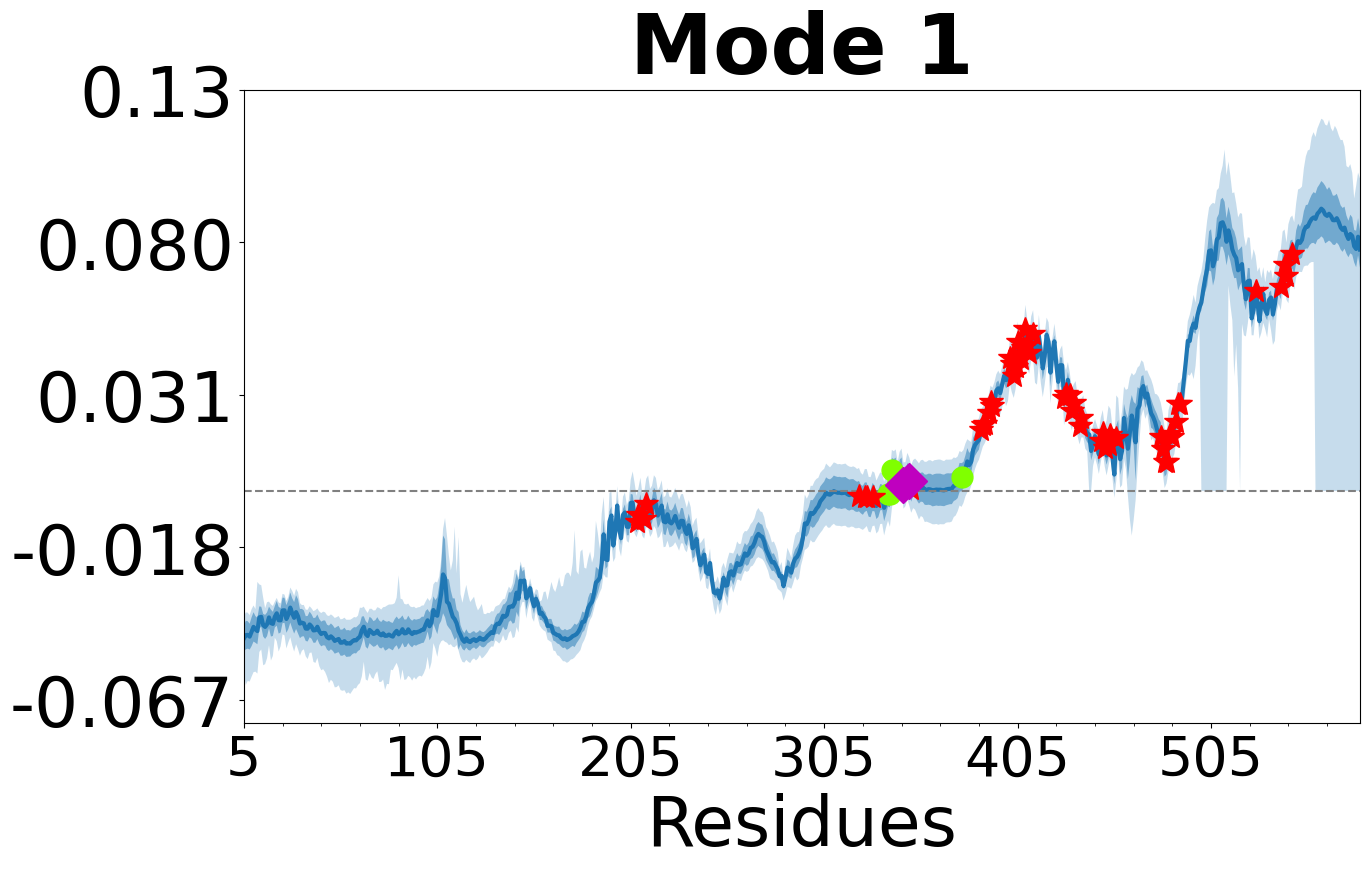

In [41]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, Hinge0)

Hinge residue with wide bands [396, 397, 398, 399, 423, 424, 192, 193, 454, 455, 456, 457, 465, 466, 467, 486, 487, 238, 239, 250, 251]
local loop motion [195, 237, 279, 402, 421, 459, 460]
current bindings are [385, 386, 387, 523, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 408, 536, 538, 539, 542, 424, 425, 427, 428, 429, 432, 433, 443, 444, 445, 318, 447, 448, 321, 322, 451, 325, 203, 204, 207, 208, 341, 344, 345, 474, 475, 476, 477, 479, 480, 482, 483, 484, 381, 382, 383]
current hits are [396, 397, 398, 399, 402, 424]
# of overlaps finding from current mode is 6


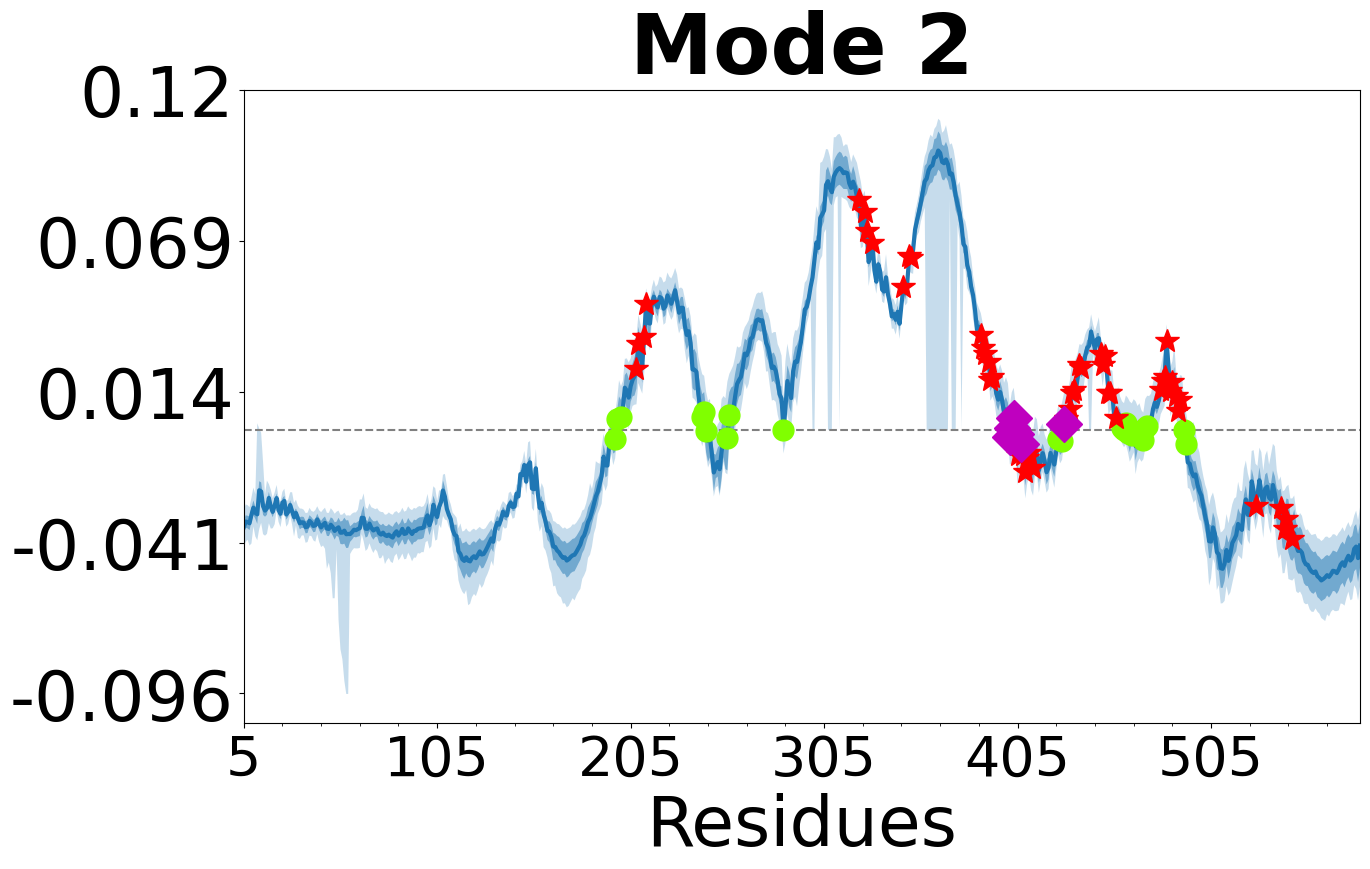

In [43]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, Hinge1)